In [1]:
import pickle
from scipy.sparse import csr_matrix
from clustering import visualize_silhouette_clusters
import numpy as np
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from soyclustering import SphericalKMeans, visualize_pairwise_distance
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# load the itemset_features variable - i created it in the Wikipedia_Mining notebook
with open('data/minsupp_0.2/itemset_features.pkl', 'rb') as f:
    itemset_features = pickle.load(f)

In [2]:
# adjust number of clusters
my_num_clusters = 20

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
itemset_matrix = csr_matrix(itemset_features.astype(int))
density = itemset_matrix.getnnz() / np.prod(itemset_matrix.shape)
print("density of matrix:", density)

spherical_kmeans = SphericalKMeans(
        n_clusters=my_num_clusters,
        max_iter=25,
        verbose=1,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

sphkmeans_cluster_labels = spherical_kmeans.fit_predict(itemset_matrix)
print('finished spherical clustering')

density of matrix: 0.24639535095527584
initialization_time=0.194198 sec, sparsity=0.1
n_iter=1, changed=3521007, inertia=3386780.998, iter_time=18.692 sec, sparsity=0.333
n_iter=2, changed=833856, inertia=2793911.495, iter_time=18.703 sec, sparsity=0.335
n_iter=3, changed=482510, inertia=2766637.602, iter_time=18.552 sec, sparsity=0.335
n_iter=4, changed=491237, inertia=2745631.276, iter_time=18.551 sec, sparsity=0.33
n_iter=5, changed=295882, inertia=2709539.158, iter_time=19.032 sec, sparsity=0.333
n_iter=6, changed=247320, inertia=2700318.525, iter_time=18.487 sec, sparsity=0.333
n_iter=7, changed=156038, inertia=2691429.327, iter_time=18.494 sec, sparsity=0.33
n_iter=8, changed=115498, inertia=2686998.625, iter_time=18.496 sec, sparsity=0.328
n_iter=9, changed=77539, inertia=2685312.134, iter_time=18.515 sec, sparsity=0.33
n_iter=10, changed=65825, inertia=2684798.548, iter_time=18.497 sec, sparsity=0.33
n_iter=11, changed=51016, inertia=2684665.982, iter_time=18.625 sec, sparsity=

For n_clusters = 7 The average silhouette_score is : 0.1541427969906234


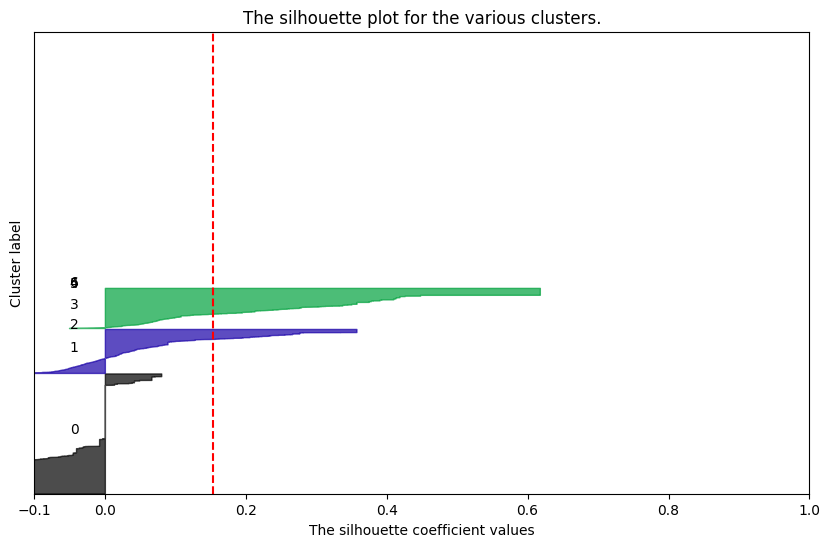

In [3]:
## Silhouette plot to visualize how good clusters are: if they are good, should see more on the right side
## Good average silhouette score apparently should be >0.5?

# Subsample before trying to do silhouette visualization, IF dataset is too big
subsample = True
if subsample:
    subsample_size = 10000  # Adjust as needed

    # Generate random indices for subsampling
    random_indices = np.random.choice(len(itemset_features), subsample_size, replace=False)

    subsample_itemset_features = itemset_features[random_indices]
    subsample_sphkmeans_cluster_labels = sphkmeans_cluster_labels[random_indices]
    visualize_silhouette_clusters(subsample_sphkmeans_cluster_labels, subsample_itemset_features, metric='cosine')
else:
    visualize_silhouette_clusters(sphkmeans_cluster_labels, itemset_features, metric='cosine')

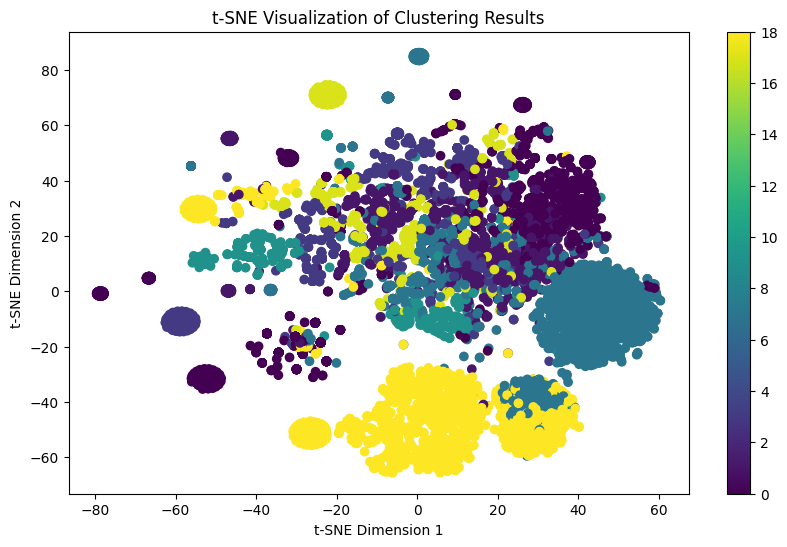

In [4]:
## using t-sne (alternative to pca) to visualize

# Calculate cosine distances between binary vectors
cosine_distances_matrix = cosine_distances(subsample_itemset_features) if subsample else cosine_distances(itemset_features)

# Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, learning_rate=200, init="random")

# Fit t-SNE to the cosine distance matrix
tsne_results = tsne.fit_transform(cosine_distances_matrix)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))

if subsample:
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=subsample_sphkmeans_cluster_labels, cmap='viridis')
else:
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Clustering Results')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


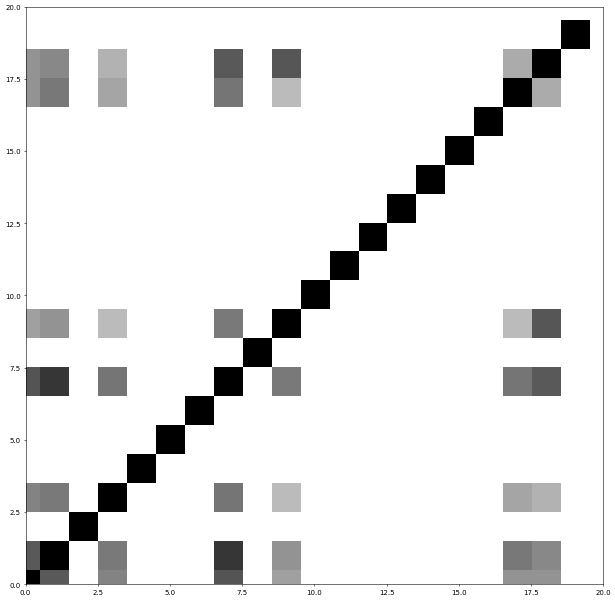

In [5]:
# function included with the sphericalkmeans library to evaluate the distance between the clusters
# dark means closer, light means further away - think ideally should have more light squares?

sphkmeans_centers = spherical_kmeans.cluster_centers_

fig = visualize_pairwise_distance(centers=sphkmeans_centers,
                                  labels=sphkmeans_cluster_labels, 
                                  max_dist=1, 
                                  sort=False)

In [ ]:
# KModes clustering

km = KModes(n_clusters=my_num_clusters, init='Huang', n_init=5, verbose=1, n_jobs=-1)
kmodes_cluster_labels = km.fit_predict(itemset_features)

if subsample:
    visualize_silhouette_clusters(kmodes_cluster_labels[random_indices],
                                  itemset_features[random_indices],
                                  metric='cosine')
else:
    visualize_silhouette_clusters(kmodes_cluster_labels, itemset_features, metric='cosine')

In [ ]:
# Agglomerative clustering

agglo_cluster_labels = AgglomerativeClustering(n_clusters=my_num_clusters, metric="cosine", linkage="average")

if subsample:
    visualize_silhouette_clusters(agglo_cluster_labels[random_indices], itemset_features[random_indices], metric='cosine')
else:
    visualize_silhouette_clusters(agglo_cluster_labels, itemset_features, metric='cosine')

In [ ]:
# extra

#agglomerative clustering

# from sklearn.metrics.pairwise import cosine_similarity
# Compute the cosine similarity matrix
# similarity = cosine_similarity(itemset_features)
# print(similarity.__sizeof__()/1024)
